In [166]:
# !pip install shap

In [167]:
# !pip install eli5

In [168]:
# !pip install hyperopt

In [204]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
# from catboost import Pool, CatBoostClassifier
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

import shap
import eli5

In [170]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

## Загрузка данных

In [171]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 22 columns):
Exposure       40732 non-null float64
LicAge         40732 non-null int64
RecordBeg      40732 non-null object
RecordEnd      21616 non-null object
VehAge         40732 non-null object
Gender         40732 non-null object
MariStat       40732 non-null object
SocioCateg     40732 non-null object
VehUsage       40732 non-null object
DrivAge        40732 non-null int64
HasKmLimit     40732 non-null int64
BonusMalus     40732 non-null int64
VehBody        40732 non-null object
VehPrice       40732 non-null object
VehEngine      40732 non-null object
VehEnergy      40732 non-null object
VehMaxSpeed    40732 non-null object
VehClass       40732 non-null object
ClaimAmount    40732 non-null float64
RiskVar        40732 non-null float64
Garage         40732 non-null object
ClaimInd       40732 non-null int64
dtypes: float64(3), int64(5), object(14)
memory usage: 6.8+ MB


In [172]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


## Предобработка данных

In [173]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
231,-200.867674,0
404,-381.646224,0
568,-289.837160,0
794,-528.762236,0
822,-27.029003,0


In [174]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [175]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [176]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


### Категориальные признаки

In [177]:
cat_features = ['SocioCateg', 'VehAge', 'VehUsage', 'VehBody', 'VehPrice', 'VehEngine', 'VehEnergy', 'VehMaxSpeed', 'VehClass', 'Garage']

In [179]:
for cf in cat_features:
    print(f'{cf}: ', df[cf].unique())

SocioCateg:  ['CSP1' 'CSP55' 'CSP47' 'CSP50' 'CSP60' 'CSP48' 'CSP46' 'CSP37' 'CSP26'
 'CSP42' 'CSP66' 'CSP6' 'CSP49' 'CSP51' 'CSP22' 'CSP3' 'CSP7' 'CSP73'
 'CSP74' 'CSP21' 'CSP16' 'CSP77' 'CSP40' 'CSP20' 'CSP57' 'CSP5' 'CSP62'
 'CSP2' 'CSP19' 'CSP65' 'CSP70' 'CSP18' 'CSP38' 'CSP61' 'CSP56' 'CSP41'
 'CSP91' 'CSP32' 'CSP35' 'CSP27' 'CSP59' 'CSP43' 'CSP33' 'CSP9' 'CSP39'
 'CSP28' 'CSP36' 'CSP23' 'CSP25' 'CSP30' 'CSP31' 'CSP63']
VehAge:  ['2' '0' '1' '3' '6-7' '4' '5' '10+' '8-9']
VehUsage:  ['Professional' 'Private+trip to office' 'Private' 'Professional run']
VehBody:  ['sedan' 'microvan' 'other microvan' 'van' 'cabriolet'
 'sport utility vehicle' 'station wagon' 'coupe' 'bus']
VehPrice:  ['D ' 'K ' 'L ' 'G ' 'B ' 'M ' 'P ' 'H ' 'J ' 'C ' 'N ' 'Q ' 'I ' 'F '
 'E ' 'R ' 'V ' 'O ' 'T ' 'Z ' 'A ' 'S ' 'Y ' 'U ' 'X ' 'W ' 'Z1']
VehEngine:  ['injection' 'direct injection overpowered' 'injection overpowered'
 'carburation' 'GPL' 'electric']
VehEnergy:  ['regular' 'diesel' 'GPL' 'eletric']
VehM

In [180]:
for cf in cat_features:
    if cf == 'SocioCateg':
        df['SocioCateg'] = df.SocioCateg.str.slice(0,4)
        
    df = pd.concat([df, pd.get_dummies(df[cf], prefix=cf).astype('float64')], axis=1)

In [181]:
df = df.select_dtypes(exclude=['object'])

In [182]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 97 columns):
Exposure                                  40732 non-null float64
LicAge                                    40732 non-null int64
Gender                                    40732 non-null int64
MariStat                                  40732 non-null int64
DrivAge                                   40732 non-null int64
HasKmLimit                                40732 non-null int64
BonusMalus                                40732 non-null int64
ClaimAmount                               40732 non-null float64
RiskVar                                   40732 non-null float64
ClaimInd                                  40732 non-null int64
SocioCateg_CSP1                           40732 non-null float64
SocioCateg_CSP2                           40732 non-null float64
SocioCateg_CSP3                           40732 non-null float64
SocioCateg_CSP4                           40732 non-null flo

### Оценка итогового признака

XGBoost производит оценку парамтера в диапазоне от 0. У нас диапазон начинается с 1, поэтому вычтем 1 из целевого признака RiskVar

In [184]:
df['RiskVar'] -= 1

In [185]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').count()['Exposure'].rename('Count'), columns=['Count'])

In [186]:
FreqCount['Freq'] = FreqCount['Count']/FreqCount['Count'].sum()

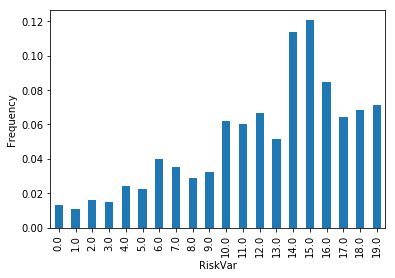

In [187]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Налицо дизбаланс признаков.  
Можно применить балансировку, но намного проще задать веса. Например, для 14 и 15 задать вес 0.5, а для остальных 1.  

In [188]:
df['weight'] = df['RiskVar'].isin([14,15])
df['weight'] = df['weight'].map({True: 1, False: 0.5})

## Разделение на тестовую, тренировочную и валидационную выборки

In [212]:
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(df.drop(['RiskVar'], axis=1), df.RiskVar, test_size=0.15, random_state=10)
x_train_r, x_valid_r, y_train_r, y_valid_r = train_test_split(x_train_r, y_train_r, test_size=0.15, random_state=10)

In [213]:
train_r = xgb.DMatrix(x_train_r.drop(['weight'], axis=1), y_train_r, weight=x_train_r['weight'])
valid_r = xgb.DMatrix(x_valid_r.drop(['weight'], axis=1), y_valid_r)
test_r = xgb.DMatrix(x_test_r.drop(['weight'], axis=1), y_test_r)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


## Подбор гиперпараметров

In [223]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': 20
    }
    
    cv_result = xgb.cv(parameters, train_r, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0, maximize=False, early_stopping_rounds=10, metrics = ["mlogloss"])
    print(cv_result)
    
    score = cv_result['test-mlogloss-mean'][-1:].values[0]
    return score


In [224]:
space = {
     #'num_boost_round': hp.quniform('num_boost_round', 50, , 1),
     'num_boost_round': hp.choice('num_boost_round', [50]),
     'max_depth': hp.choice('max_depth', [5]),
     'min_child_weight': hp.uniform('min_child_weight', 0, 5),
     'subsample': hp.uniform('subsample', 0.5, 1),
     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
     'alpha': hp.uniform('alpha', 0, 1),
     'lambda': hp.uniform('lambda', 0, 1),
     'eta': hp.uniform('eta', 0.01, 1),
}

In [225]:
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              2.927209            0.000401            2.933390   
1              2.872559            0.000709            2.884105   
2              2.826821            0.000839            2.843645   
3              2.787984            0.001345            2.809453   
4              2.754239            0.001435            2.780481   
5              2.724594            0.001649            2.755295   
6              2.698267            0.001705            2.733088   
7              2.674487            0.001431            2.713526   
8              2.653545            0.001376            2.696399   
9              2.633996            0.001435            2.680739   
10             2.616102            0.001184            2.666687   
11             2.599691            0.001284            2.653999   
12             2.584608            0.001132            2.642652   
13             2.570814            0.001276            2.63229

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \               
0              2.619738            0.001509            2.659961   
1              2.536599            0.001918            2.607197   
2              2.482110            0.001482            2.579910   
3              2.442481            0.002119            2.564224   
4              2.408218            0.002405            2.555399   
5              2.378181            0.002040            2.548360   
6              2.350519            0.001631            2.544614   
7              2.325149            0.001562            2.542238   
8              2.301358            0.001636            2.537899   
9              2.277714            0.001242            2.535433   
10             2.255709            0.001411            2.532224   
11             2.233536            0.002001            2.529521   
12             2.212440            0.002657            2.525472   
13             2.191408            0.002753    

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \     
0              2.830156            0.001107            2.841093   
1              2.739764            0.000869            2.760085   
2              2.676726            0.001078            2.705674   
3              2.629866            0.001399            2.667332   
4              2.593504            0.001609            2.638917   
5              2.564256            0.002222            2.617040   
6              2.539792            0.002055            2.600146   
7              2.518960            0.001984            2.586361   
8              2.501873            0.001891            2.575477   
9              2.486185            0.002031            2.566089   
10             2.472017            0.001700            2.558625   
11             2.458804            0.002213            2.552169   
12             2.447308            0.001892            2.546722   
13             2.436602            0.001889            2.

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \       
0              2.647937            0.002593            2.686039   
1              2.559840            0.003544            2.622321   
2              2.506299            0.002654            2.590610   
3              2.466480            0.003436            2.571083   
4              2.438262            0.002917            2.559907   
5              2.413607            0.004108            2.552048   
6              2.391582            0.005779            2.547173   
7              2.371619            0.005009            2.542739   
8              2.353897            0.004023            2.539746   
9              2.337307            0.005034            2.536696   
10             2.320151            0.004983            2.534530   
11             2.303974            0.004511            2.532616   
12             2.288808            0.003446            2.530240   
13             2.272620            0.003079            

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \       
0              2.813551            0.001028            2.835867   
1              2.712727            0.001680            2.752471   
2              2.640281            0.002026            2.696374   
3              2.585883            0.002941            2.656173   
4              2.542150            0.003149            2.625982   
5              2.505508            0.003430            2.603025   
6              2.474145            0.003176            2.584436   
7              2.446647            0.003399            2.569853   
8              2.422924            0.003349            2.558346   
9              2.400737            0.003200            2.548134   
10             2.380686            0.002784            2.539377   
11             2.362182            0.003402            2.532034   
12             2.344448            0.003843            2.525794   
13             2.328268            0.003853            

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \        
0              2.799191            0.001061            2.816862   
1              2.701365            0.001240            2.732696   
2              2.635344            0.000326            2.678933   
3              2.587620            0.000543            2.641369   
4              2.550403            0.001050            2.614464   
5              2.520810            0.001259            2.594726   
6              2.495929            0.001035            2.579247   
7              2.474616            0.000888            2.567248   
8              2.456735            0.000386            2.557599   
9              2.440408            0.001053            2.549756   
10             2.425587            0.001038            2.543387   
11             2.411724            0.001477            2.537935   
12             2.399568            0.001218            2.533581   
13             2.387308            0.001046           

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \        
0              2.700408            0.001547            2.728410   
1              2.606351            0.002482            2.654178   
2              2.544425            0.001532            2.611193   
3              2.500820            0.001117            2.585466   
4              2.467287            0.000982            2.567480   
5              2.440113            0.001633            2.555803   
6              2.416839            0.001913            2.547508   
7              2.395990            0.002446            2.541360   
8              2.377743            0.001903            2.536541   
9              2.360360            0.001690            2.532296   
10             2.343814            0.002144            2.528773   
11             2.326883            0.002601            2.525547   
12             2.311618            0.003020            2.522685   
13             2.298571            0.002739           

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \        
0              2.788344            0.001394            2.807601   
1              2.690030            0.001197            2.722879   
2              2.624202            0.000797            2.669983   
3              2.575879            0.001712            2.633708   
4              2.538747            0.001437            2.608504   
5              2.508924            0.001055            2.590151   
6              2.483556            0.001853            2.576169   
7              2.461949            0.001870            2.565048   
8              2.442800            0.001891            2.556346   
9              2.424499            0.002042            2.549188   
10             2.408122            0.002193            2.543494   
11             2.393723            0.001955            2.538931   
12             2.379564            0.002158            2.535197   
13             2.366695            0.002400           

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \           
0              2.780217            0.002133            2.799075   
1              2.683129            0.002367            2.715585   
2              2.619543            0.001803            2.664168   
3              2.573592            0.002113            2.629418   
4              2.538735            0.002700            2.605272   
5              2.511138            0.003091            2.588989   
6              2.488193            0.002915            2.575679   
7              2.469069            0.003031            2.566131   
8              2.452344            0.003725            2.558107   
9              2.437014            0.004394            2.552264   
10             2.422979            0.004248            2.547653   
11             2.409912            0.004605            2.543808   
12             2.398041            0.005037            2.541094   
13             2.386621            0.004904        

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \           
0              2.642988            0.002046            2.674284   
1              2.563344            0.003572            2.617651   
2              2.513126            0.002392            2.588027   
3              2.476876            0.002101            2.572165   
4              2.449539            0.002660            2.561800   
5              2.424702            0.002750            2.554900   
6              2.401946            0.003264            2.550268   
7              2.380689            0.003710            2.546823   
8              2.361899            0.003400            2.543628   
9              2.344536            0.003720            2.541613   
10             2.327050            0.004077            2.539043   
11             2.310973            0.004559            2.537270   
12             2.294704            0.003991            2.534861   
13             2.278746            0.002612        

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \           
0              2.583456            0.004555            2.655693   
1              2.478680            0.003639            2.610537   
2              2.412190            0.003675            2.593181   
3              2.361085            0.004702            2.585354   
4              2.315980            0.006543            2.581503   
5              2.272629            0.005658            2.579819   
6              2.234292            0.004920            2.578137   
7              2.196756            0.004789            2.577358   
8              2.162436            0.004484            2.577368   
9              2.129703            0.005355            2.577119   
10             2.096313            0.007782            2.575280   
11             2.063490            0.007821            2.574470   
12             2.032401            0.008733            2.573886   
13             2.000789            0.009433        

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \           
0              2.845376            0.001035            2.863065   
1              2.752571            0.001372            2.785083   
2              2.683801            0.001306            2.729775   
3              2.630507            0.001971            2.687696   
4              2.587353            0.002335            2.655981   
5              2.550952            0.002578            2.630348   
6              2.520169            0.002222            2.609810   
7              2.493291            0.002825            2.592757   
8              2.469896            0.002710            2.579289   
9              2.448231            0.003037            2.566962   
10             2.428490            0.002774            2.556978   
11             2.410788            0.003120            2.548240   
12             2.394943            0.002970            2.540738   
13             2.379570            0.002983        

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \          
0              2.708675            0.002083            2.742855   
1              2.604174            0.002556            2.663398   
2              2.535725            0.002624            2.618107   
3              2.485800            0.004026            2.590058   
4              2.446766            0.004473            2.570705   
5              2.413619            0.005001            2.558521   
6              2.385430            0.004249            2.548620   
7              2.358861            0.003845            2.541404   
8              2.335850            0.003187            2.534829   
9              2.313863            0.003356            2.530503   
10             2.293696            0.003620            2.526806   
11             2.273885            0.004246            2.523470   
12             2.255062            0.003032            2.519959   
13             2.236312            0.002601         

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.888903            0.000632            2.899254   
1              2.813064            0.000760            2.833026   
2              2.754063            0.001017            2.782822   
3              2.706662            0.001614            2.742894   
4              2.666893            0.001840            2.710753   
5              2.632957            0.002339            2.684262   
6              2.603745            0.002413            2.661611   
7              2.577740            0.002225            2.642405   
8              2.555157            0.002237            2.625932   
9              2.534614            0.002187            2.611704   
10             2.516004            0.001811            2.599410   
11             2.499358            0.002291            2.588690   
12             2.484266            0.002016            2.579392   
13             2.470469            0.002072          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.938081            0.000533            2.944117   
1              2.890124            0.000917            2.902348   
2              2.848289            0.000638            2.866103   
3              2.811488            0.000570            2.834560   
4              2.778924            0.000406            2.807230   
5              2.749943            0.000822            2.783059   
6              2.723685            0.000979            2.761476   
7              2.699439            0.001097            2.742185   
8              2.677498            0.001078            2.724623   
9              2.656930            0.001317            2.708686   
10             2.638188            0.001148            2.694263   
11             2.620937            0.001045            2.680995   
12             2.604961            0.000838            2.668871   
13             2.589902            0.001098          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.816977            0.000729            2.833546   
1              2.720080            0.001148            2.751257   
2              2.651680            0.001371            2.695217   
3              2.600964            0.001240            2.655552   
4              2.561129            0.001264            2.626505   
5              2.527537            0.001615            2.604651   
6              2.499429            0.001736            2.587000   
7              2.475062            0.002156            2.573486   
8              2.454959            0.002127            2.562611   
9              2.435990            0.002449            2.553733   
10             2.418823            0.002746            2.546486   
11             2.402674            0.002998            2.540547   
12             2.388130            0.003142            2.535304   
13             2.374629            0.003317          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.649113            0.002047            2.683388   
1              2.564215            0.003810            2.624024   
2              2.510607            0.003157            2.592353   
3              2.471006            0.004214            2.575789   
4              2.440589            0.004498            2.565617   
5              2.413211            0.003963            2.558742   
6              2.388798            0.003615            2.554464   
7              2.366069            0.005087            2.549734   
8              2.346589            0.003816            2.546431   
9              2.325991            0.004536            2.544256   
10             2.306842            0.004837            2.544955   
11             2.289183            0.004736            2.542735   
12             2.271135            0.005210            2.541903   
13             2.253967            0.004339          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.750022            0.001930            2.777546   
1              2.645552            0.002605            2.691988   
2              2.576563            0.002579            2.641215   
3              2.526079            0.003369            2.607574   
4              2.487410            0.003857            2.584199   
5              2.455759            0.004446            2.566970   
6              2.428474            0.003929            2.554030   
7              2.404642            0.003750            2.544101   
8              2.383521            0.004681            2.536312   
9              2.364200            0.004719            2.529869   
10             2.346162            0.004130            2.524583   
11             2.328687            0.004036            2.519512   
12             2.312624            0.003856            2.514847   
13             2.296740            0.003492          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.724525            0.001022            2.755114   
1              2.622624            0.000652            2.674614   
2              2.556866            0.001204            2.629075   
3              2.509288            0.002043            2.601152   
4              2.472817            0.002410            2.580854   
5              2.441222            0.003060            2.567318   
6              2.414409            0.002946            2.557069   
7              2.390128            0.003319            2.549589   
8              2.369375            0.003076            2.544271   
9              2.348138            0.003010            2.541244   
10             2.328447            0.003832            2.537058   
11             2.310369            0.004203            2.533872   
12             2.292830            0.004631            2.531712   
13             2.276525            0.004295          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.691022            0.002188            2.718304   
1              2.598571            0.003689            2.645914   
2              2.539733            0.003725            2.605067   
3              2.497960            0.002529            2.581139   
4              2.464897            0.003423            2.565328   
5              2.436898            0.002466            2.553565   
6              2.414241            0.002498            2.544971   
7              2.393802            0.002169            2.538547   
8              2.375153            0.002191            2.534115   
9              2.358360            0.003065            2.529536   
10             2.341447            0.003101            2.525404   
11             2.325399            0.002784            2.522566   
12             2.310190            0.003216            2.519384   
13             2.295944            0.003678          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.928498            0.000399            2.934843   
1              2.874439            0.000633            2.886394   
2              2.828964            0.000607            2.846596   
3              2.789884            0.001139            2.812659   
4              2.755966            0.001330            2.783911   
5              2.725834            0.001689            2.758654   
6              2.698913            0.001762            2.736481   
7              2.674663            0.001538            2.716975   
8              2.652848            0.001628            2.699504   
9              2.632735            0.001736            2.683666   
10             2.614294            0.001422            2.669567   
11             2.597435            0.001550            2.656987   
12             2.581821            0.001496            2.645550   
13             2.567353            0.001601          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \         
0              2.799830            0.000602            2.818483   
1              2.701887            0.002216            2.734401   
2              2.636163            0.001631            2.681157   
3              2.587257            0.001955            2.643653   
4              2.549775            0.002670            2.616596   
5              2.519079            0.003113            2.596922   
6              2.493156            0.002886            2.581621   
7              2.471369            0.003361            2.569697   
8              2.452678            0.002882            2.560404   
9              2.435078            0.003278            2.552560   
10             2.418659            0.003169            2.546400   
11             2.403968            0.003304            2.541277   
12             2.390438            0.003262            2.536813   
13             2.377428            0.003794          

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \       
0              2.620814            0.002705            2.665001   
1              2.539868            0.002065            2.610811   
2              2.489120            0.002345            2.584526   
3              2.452280            0.003711            2.570471   
4              2.424004            0.004851            2.560560   
5              2.398854            0.005262            2.556126   
6              2.376575            0.004598            2.551055   
7              2.354907            0.002771            2.548045   
8              2.336671            0.003110            2.545291   
9              2.317056            0.003383            2.542509   
10             2.299086            0.002912            2.540839   
11             2.280748            0.003112            2.539353   
12             2.263382            0.003342            2.536945   
13             2.246485            0.002407            

100%|██████████| 50/50 [19:27:47<00:00, 2307.41s/it, best loss: 2.4351936]


Очень медленно... Просто невероятно :)

In [231]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 20
best_params

{'alpha': 0.2076267654194816,
 'colsample_bytree': 0.9127479422793643,
 'eta': 0.43978026798627773,
 'lambda': 0.5378279788816703,
 'max_depth': 5,
 'min_child_weight': 0.1410668140410778,
 'num_boost_round': 50,
 'subsample': 0.9949799596069517,
 'objective': 'multi:softmax',
 'num_class': 20}

## Обучаем модель

In [232]:
es_model = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_r, maximize=False, evals=[(train_r, "train"),(valid_r, "valid")], early_stopping_rounds=10, verbose_eval=False)

In [234]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = 20
best_params

model = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_r, maximize=False, evals=[(train_r, "train"),(valid_r, "valid")], verbose_eval=False)

## Оценим полученную модель

In [236]:
dfsets = [{'set': 'train', 'dmat': train_r, 'target': y_train_r},
          {'set': 'valid', 'dmat': valid_r, 'target': y_valid_r},
          {'set': 'test', 'dmat': test_r, 'target': y_test_r}]
for dfset in dfsets:
    class_preds = es_model.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.37559467174119887
F1 Score on valid: 0.2019638043896804
F1 Score on test: 0.19148936170212763


Видим довольно низкий F1.  
Идеи по улучшению:  
- во-первых, получше подобрать гиперпараметры  
- во-вторых, применить другую модель (например Catboost) для работы с категориальными парамтерами